In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 

import matplotlib.pyplot as plt 


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 14, 'font.family': 'Arial'})

In [ ]:
# Nutrient variation Challenge
file_name = './output/reduced_model_ETC_core_20250228-213124_continuous_steady_state_robustness_each_fuel_10_fold.csv'
results = pd.read_csv(file_name, index_col=0)

# Result 
file_name = './output/reduced_model_ETC_core_20250228-213124_continuous_steady_state_robustness_each_fuel_10_fold_no_reg.csv'
results_no_reg = pd.read_csv(file_name, index_col=0)

In [3]:
# Compute the difference 
ref_atp_production_per_parameter = results[results.pertubration == 1.0].groupby('parameter_set')['cyt_atp2adp'].mean()
ref_atp_production_per_parameter_no_reg = results_no_reg[results_no_reg.pertubration == 1.0]\
                                                .groupby('parameter_set')['cyt_atp2adp'].mean()

In [4]:
ref_atp_production_per_parameter

parameter_set
0,5      6.579010
0,6      6.579010
0,7      6.579010
1,0      6.577649
1,1      6.577649
           ...   
999,3    6.595925
999,5    6.595925
999,7    6.595925
999,8    6.595925
999,9    6.595925
Name: cyt_atp2adp, Length: 7707, dtype: float64

In [5]:
# Drop 1.0 perturbations
results = results[results['pertubration'] != 1.0]
results_no_reg = results_no_reg[results_no_reg['pertubration'] != 1.0]

In [6]:
# Merge in ref_atp_production_per_parameter
results = results.merge(ref_atp_production_per_parameter.rename('ref_atp_production'),
                        left_on='parameter_set', right_index=True)

results_no_reg = results_no_reg.merge(ref_atp_production_per_parameter_no_reg.rename('ref_atp_production'),
                                      left_on='parameter_set', right_index=True)

In [7]:
# Compute if atp production is robust difference from reference
tolerance = 0.5  
atp_production_robust = (results['cyt_atp2adp'] - results['ref_atp_production']).abs() < tolerance
atp_production_robust_no_reg = (results_no_reg['cyt_atp2adp'] - results_no_reg['ref_atp_production']).abs() < tolerance

# Add robustness column
results['atp_production_robust'] = atp_production_robust
results_no_reg['atp_production_robust'] = atp_production_robust_no_reg


In [8]:
# Addd is_robust column if atp_production_robust and is_steady_state
results['is_robust'] = results['atp_production_robust'] & results['is_steady_state']
results_no_reg['is_robust'] = results_no_reg['atp_production_robust'] & results_no_reg['is_steady_state']

In [9]:
def plot_robustness_analysis(results_df, figsize=(10, 4)):
    """
    Create visualization showing parameter set success rate distribution and 
    steady-state success rate heatmap by parameter and perturbation.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        DataFrame containing robustness analysis results with columns:
        'parameter_set', 'is_steady_state', 'pertubration', 'parameter'
    figsize : tuple, optional
        Figure size (width, height) in inches. Default is (15, 6)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure object
    axes : numpy.ndarray
        Array of subplot axes
    """
    
    # Calculate parameter set analysis for the distribution plot
    parameter_set_analysis = results_df.groupby('parameter_set').agg({
        'is_robust': ['count', 'sum'],
        'pertubration': 'nunique',
        'parameter': 'nunique'
    }).round(3)

    parameter_set_analysis.columns = ['Total_Tests', 'robust_count', 'Num_Perturbations', 'Num_Parameters']
    parameter_set_analysis['Success_Rate'] = parameter_set_analysis['robust_count'] / parameter_set_analysis['Total_Tests']

    # Create figure with 1x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # 1. Distribution of success rates across parameter sets
    ax1 = axes[0]
    bins = np.linspace(0, 1, 13)  # 12 bins from 0 to 1
    ax1.hist(parameter_set_analysis['Success_Rate'], 
             bins=bins, color='grey', edgecolor='black')

    ax1.set_xlabel('Nutrient challenge success rate')
    ax1.set_ylabel('Number of Parameter Sets')

    ax1.legend(frameon=False)

    sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)


    # 2. Heatmap: Success rate by parameter and perturbation
    heatmap_data = results_df.pivot_table(
        values='is_robust', 
        index='parameter', 
        columns='pertubration', 
        aggfunc='mean'
    )

    # Rename columns to more readable format 0.1 -> 10 fold down
    heatmap_data.columns = [f'{int(1/factor)} fold down' if factor < 1 else f'{int(factor)} fold up' 
                            for factor in heatmap_data.columns]
    
    # Change the index to be more readable
    heatmap_data.index = heatmap_data.index.map({
        'glc_D_e': 'Glucose',
        'lac_L_e': 'Lactate',
        'hdca_e': 'Fatty acids',
        'bhb_e': '3HB'
    })


    cmap = sns.color_palette("dark:salmon_r", as_cmap=True)
    #sns.diverging_palette(30, 250, l=65, center="dark", as_cmap=True)

    ax2 = axes[1]
    sns.heatmap(heatmap_data, annot=True, fmt='.2%', cmap=cmap,
                cbar_kws={'label': 'Success rate'}, ax=ax2,
                vmin=0, vmax=1)
    ax2.set_ylabel('Pertrubed nutrient')

    # Map parameter names to more readable format
    # glc_D_e -> Glucose, lac_L_e -> Lactate, 
    # hdca_e -> Hexadecanoate, bhb_c -> 3HB
    parameter_mapping = {
        'glc_D_e': 'Glucose',
        'lac_L_e': 'Lactate',
        'hdca_e': 'Fatty acids',
        'bhb_e': '3HB'
    }
    ax2.set_yticklabels([parameter_mapping.get(label, label) 
                         for label in ax2.get_yticklabels()],
                         rotation=0)   

    # Adjust layout for better spacing

    plt.tight_layout()
    return fig, axes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


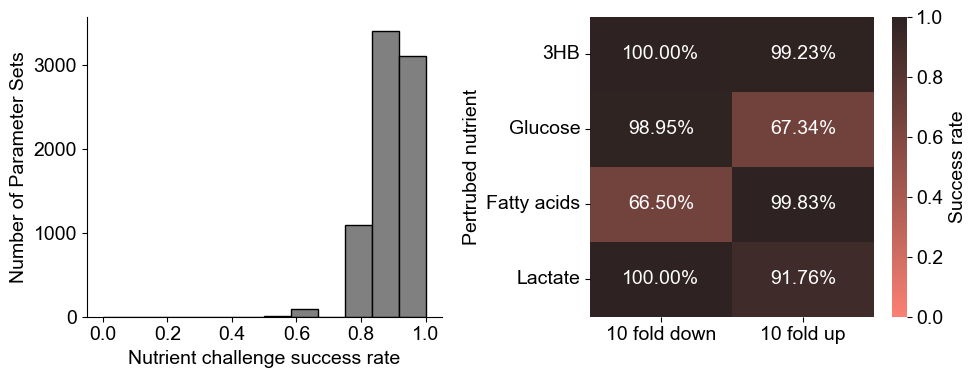

In [10]:
# Call the function to create the plots
fig, axes = plot_robustness_analysis(results)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


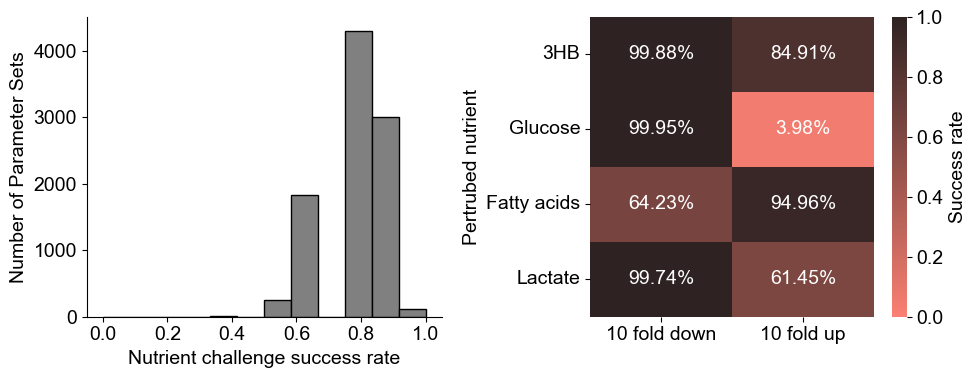

In [11]:
fig_no_reg, axes_no_reg = plot_robustness_analysis(results_no_reg)


In [ ]:
# Save the figures
fig.savefig('./output/robustness_to_fuel_perturbations.svg', bbox_inches='tight')
fig_no_reg.savefig('./output/robustness_to_fuel_perturbations_no_reg.svg', bbox_inches='tight')